# Beispiel nichtlineares Randwertproblem

Als Beispiel betrachten wir das folgende nichtlineare Randwertproblem

$$\begin{split}-u''(x) + u(x)^3 & = -3+\frac{1}{8}(4-7 x+3 x^2)^3\\
u(0) & = 2\\
u(2) & = 1.\end{split}$$

Die exakte Lösung ist gegeben durch

$$u_{\text{exact}} = \frac{1}{2} (4-7 x+3 x^2).$$

In [1]:
from netgen.meshing import Mesh as NGMesh
from netgen.meshing import MeshPoint, Element0D, Element1D, Pnt
from ngsolve import *

import matplotlib.pyplot as plt
import numpy as np

importing NGSolve-6.2.2204-53-g6741b8aa5


1D Mesh erstellen: (2 Elemente mit Intervall Länge 2)

In [2]:
# generate a 1D mesh
ngmesh = NGMesh()
ngmesh.dim = 1

nel = 1
l0 = 2

pnums = []
for i in range(0, nel+1):
    pnums.append (ngmesh.Add(MeshPoint (Pnt(i/nel*l0, 0, 0))))

for i in range(0,nel):
    ngmesh.Add (Element1D([pnums[i],pnums[i+1]], index=1))

ngmesh.Add (Element0D(pnums[0], index=1))
ngmesh.Add (Element0D(pnums[nel], index=2))

mesh = Mesh(ngmesh)

FE-Space und Trial, Test Proxyfunktionen für die Definition der schwachen Gleichung

In [3]:
order = 2
V = H1(mesh, order=order, dirichlet=[1,2])
u,v = V.TnT()
gfu = GridFunction(V)

Durch partielle Integration des ersten Terms und für $v\in V=H_0^1([0,2])$ gilt

$$F(u) v = \int_0^2u'(x) v'(x)\, dx + \int_0^2u(x)^3 v(x)\,dx - \int_0^2(-3+\frac{1}{8}(4-7 x+3 x^2)^3)\, v(x)\, dx = 0 \quad \forall v \in V$$

In [4]:
a = BilinearForm(V)
a += (grad(u)*grad(v)+u**3*v-(-3+1/8*(4-7*x+3*x*x)**3)*v)*dx

Die Variation von $F(u)$ ist gegeben durch

$$F'(u)w v = \frac{d}{d\varepsilon} F(u+\epsilon w) v \Big|_{\varepsilon=0} = \int_0^2w'(x) v'(x) + 3\,u(x)^2 w(x) v(x)\, dx \quad \forall w, v \in V$$

In [5]:
a1 = BilinearForm(V)
a1 += (grad(u)*grad(v)+3*gfu**2*u*v)*dx

oder mit Hilfe von Computer Algebra in NGSolve:

In [6]:
a.AssembleLinearization(gfu.vec)

Die Dirichlet Randbedingung wird für den Lösungsvektor gesetzt

In [7]:
u0 = CoefficientFunction([2,1])
gfu.Set(u0,BND)

Mit Hilfe der Newton Iteration wird das System gelöst.

$$F(u)v = 0\quad \forall\ v\in V$$

```{prf:algorithm} Newton Verfahren
:label: my-alg-NewtonVerfahren

Given $u_0$ <br>
for $n = 0, 1, 2, \ldots$ <br>
$\qquad r_n = F(u_n)$ <br>
$\qquad F'(u_n)\cdot \delta u = r_n$ <br>
$\qquad u_{n+1} = u_n - \delta u$
```

```{admonition} Aufgabe 
Berechne die Linearisierung von $F(u)$.
```

In [8]:
res = gfu.vec.CreateVector()
du  = gfu.vec.CreateVector()

for it in range(10):
    print ("Newton iteration", it)

    # solve linearized problem:
    # F(u_n)
    a.Apply (gfu.vec, res)
    
    # F'(u_n)
    a.AssembleLinearization(gfu.vec)
    # oder alternativ das die selber berechnete Variation
    #a1.Assemble()
    
    # F'(u_n) du = F(u_n)
    du.data = a.mat.Inverse(V.FreeDofs()) * res
    # oder alternativ das die selber berechnete Variation
    #du.data = a1.mat.Inverse(V.FreeDofs()) * res

    # update iteration
    # u_n+1 = u_n - du
    gfu.vec.data -= du

    #stopping criteria
    stopcritval = sqrt(abs(InnerProduct(du,res)))
    print ("<A u",it,", A u",it,">_{-1}^0.5 = ", stopcritval)
    if stopcritval < 1e-13:
        break

Newton iteration 0
<A u 0 , A u 0 >_{-1}^0.5 =  2.63044945649285
Newton iteration 1
<A u 1 , A u 1 >_{-1}^0.5 =  1.1461868091843588
Newton iteration 2
<A u 2 , A u 2 >_{-1}^0.5 =  0.23956338535903238
Newton iteration 3
<A u 3 , A u 3 >_{-1}^0.5 =  0.004330380345703788
Newton iteration 4
<A u 4 , A u 4 >_{-1}^0.5 =  6.498623278264114e-07
Newton iteration 5
<A u 5 , A u 5 >_{-1}^0.5 =  1.444693506846862e-14


In [9]:
def uexact(x):
    return 0.5*(4-7*x+3*x*x)

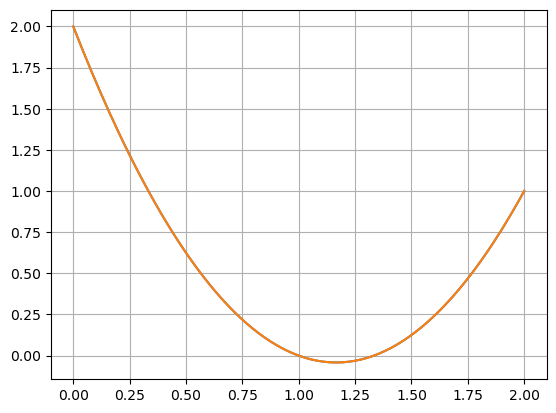

In [10]:
xi = np.linspace(0,l0,150)
ui = [gfu(xip) for xip in xi]

plt.plot(xi,ui)
plt.plot(xi,uexact(xi))
plt.grid()
plt.show()

Für den Fehler in der $L_2$-Norm folgt

In [11]:
Integrate((gfu-uexact(x))**2,mesh)**0.5

4.0864318637854154e-15

Der Fehler ist numerisch Null, da wir Elemente 2. Ordnung für ein Lösungpolynom 2. Ordnung benutzen. 

**Lösung mit zugehörigem Funktional**

Wir haben im Kapitel Variationsrechnung gesehen, dass die schwache Gleichung die Nullstellengleichung der ersten Variation eines eines zugehören Funktionals sind. Es gilt daher das notwendige Kriterium

$$J(u) = \min_{v\in V} J(v)\qquad\Rightarrow\qquad \delta J(u)\,v = 0\quad \forall v\in V.$$

In NGSolve können wir einer Bilinearform die Variation eines zu definierenden Funktionals zuordnen: 

```{admonition} Aufgabe 
* Wie lautet das zugehörige Funktional $J(u)$?
* Berechne die zweite Variation $\delta^2 J(u)(v\, w)$ von $J(u)$.
```

In [12]:
u = V.TrialFunction()

# def BilinearForm
a2 = BilinearForm(V)
a2 += Variation((1/2*grad(u)*grad(u)+1/4*u**4-(-3+1/8*(4-7*x+3*x*x)**3)*u)*dx)

In [13]:
gfue = GridFunction(V)
gfue.Set(u0,BND)

In [14]:
for it in range(10):
    print ("Newton iteration", it)

    # solve linearized problem:
    # F(u_n)
    a2.Apply(gfue.vec, res)
    # F'(u_n)
    a2.AssembleLinearization(gfue.vec)
    # F'(u_n) du = F(u_n)
    du.data = a2.mat.Inverse(V.FreeDofs()) * res


    # update iteration
    # u_n+1 = u_n - du
    gfue.vec.data -= du

    #stopping criteria
    stopcritval = sqrt(abs(InnerProduct(du,res)))
    print ("<A u",it,", A u",it,">_{-1}^0.5 = ", stopcritval)
    if stopcritval < 1e-13:
        break

Newton iteration 0
<A u 0 , A u 0 >_{-1}^0.5 =  2.63044945649285
Newton iteration 1
<A u 1 , A u 1 >_{-1}^0.5 =  1.1461868091843588
Newton iteration 2
<A u 2 , A u 2 >_{-1}^0.5 =  0.23956338535903238
Newton iteration 3
<A u 3 , A u 3 >_{-1}^0.5 =  0.004330380345703788
Newton iteration 4
<A u 4 , A u 4 >_{-1}^0.5 =  6.498623278264114e-07
Newton iteration 5
<A u 5 , A u 5 >_{-1}^0.5 =  1.444693506846862e-14


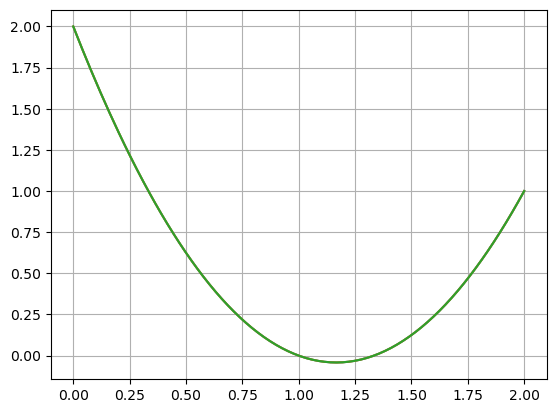

In [15]:
gfuei = [gfue(xip) for xip in xi]

plt.plot(xi,ui,label='1. Lösung')
plt.plot(xi,gfuei,label='2. Lösung')
plt.plot(xi,uexact(xi), label='exakte Lösung')
plt.grid()
plt.show()